In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def generateB(u0, rho, gamma, p):
    B = np.array([
        u0, rho, zero_vec, zero_vec, 
        zero_vec, u0, zero_vec, 1/rho, 
        zero_vec, zero_vec, u0, zero_vec, 
        zero_vec, gamma * p, zero_vec, u0
    ])
    return B
    
def numerical_flux(rho, u, v, p, e):
    flux = np.array([rho * u, rho*u**2 + p, rho * u * v, u * (e + p)])
    return flux 
def eigen_val(gamma, u, p, rho):
    c = np.sqrt(gamma * p / rho)
    eig1 = u - c
    eig2 = u
    eig3 = u + c
    return eig1, eig2, eig3
    
def lambda_star(LR,LL,rho_i1, u_i1, rho_i, u_i,p_i1, p_i):
    fz = LR * rho_i1 * u_i1 - LL * rho_i * u_i - (rho_i1 * u_i1**2 + p_i1 - rho_i * u_i**2 - p_i)
    fm = LR * rho_i1 - LL * rho_i - (rho_i1 * u_i1 - rho_i * u_i)
    lam_star = fz / fm
    return lam_star

def QL_star(LL, LS, u_i, rho_i, e_i, p_i, v_i):
    rhoL_star = (LL - u_i) * rho_i/(LL - LS)
    eL_star = (LL - u_i)*e_i/(LL - LS) + (LS - u_i) * p_i/(LL - LS) + rho_i*LS*(LS - u_i)*(LL - u_i)/(LL - LS)
    QL = np.array([[rhoL_star, rhoL_star*LS, rhoL_star *v_i, eL_star]]).T
    return QL

def QR_star(LR, LS, u_i1, rho_i1, e_i1, p_i1, v_i1):
    rhoR_star = (LR - u_i1) * rho_i1/(LR - LS)
    eR_star = (LR - u_i1)*e_i1/(LR - LS) + (LS - u_i1) * p_i1/(LR - LS) + rho_i1*LS*(LS - u_i1)*(LR - u_i1)/(LR - LS)
    QR = np.array([[rhoR_star, rhoR_star*LS, rhoR_star *v_i1, eR_star]]).T
    return QR
    
def CalcVar(Q):
    r1 = Q[0]
    u = Q[1]/r1
    v = Q[2]/r1
    e = Q[3]
    p = (e - 1/2 * r1 *(u**2 + v**2)) * (gamma - 1)
    return r1, u, v, e, p
    
def Compute_Scheme_Flux(Q1, Q2):
    
    rho_i,u_i, v_i, e_i,p_i = CalcVar(Q1)
    rho_i1,u_i1, v_i1, e_i1, p_i1 = CalcVar(Q2)

    ci = np.sqrt(gamma * p_i/rho_i)
    ci1 = np.sqrt(gamma * p_i1/rho_i1)

    LL = np.minimum(u_i - ci, u_i1 - ci1)
    LR = np.maximum(u_i + ci, u_i1 + ci1)
    LS = lambda_star(LR, LL,rho_i1, u_i1, rho_i, u_i,p_i1, p_i)
    
    if LL >= 0:
        NumeF = numerical_flux(rho_i, u_i, v_i, p_i, e_i)
        
    if (LL < 0) and (LS > 0):
        QL_S = QL_star(LL, LS, u_i, rho_i, e_i, p_i, v_i).flatten()
        FQi = numerical_flux(rho_i, u_i, v_i, p_i, e_i)
        NumeF = FQi + LL * (QL_S - Q1)
        
    if (LS<=0) and (LR >0):
        QR_S = QR_star(LR, LS, u_i1, rho_i1, e_i1, p_i1, v_i1).flatten()
        FQi = numerical_flux(rho_i1, u_i1, v_i1, p_i1, e_i1)
        NumeF = FQi + LR * (QR_S - Q2)
    
    if LR<=0:
        NumeF = numerical_flux(rho_i1, u_i1, v_i1, p_i1, e_i1)
        
    else:
        
        FQ1 = numerical_flux(rho_i, u_i, v_i, p_i, e_i)
        FQ2 = numerical_flux(rho_i1, u_i1, v_i1, p_i1, e_i1)
        NumeF = (LR * FQ1 - LL * FQ2 + LL * LR *(Q2 - Q1))/(LR - LL)  
        
    return NumeF

def Parse_var(Q):
    r1 = Q[0,:]
    u = Q[1,:]/r1
    v = Q[2,:]/r1
    e = Q[3,:]
    p = (e - 1/2 * r1 *(u**2 + v**2)) * (gamma - 1)
    return r1, u, v, e, p


In [2]:
gamma = 7/5
def Numerical_Solu(t_f, N, ts):
    cn = N
    x_dist = np.linspace(1/N, 1 - 1/N, N)
    rho = np.ones(N)
    u0 = np.zeros(N)
    v = np.zeros(N)
    v[np.where(x_dist<0.5)] = -10
    v[np.where(x_dist>0.5)] = 20
    p = np.zeros(N)
    p[np.where(x_dist<0.1)] = 1000
    p[np.where((x_dist>0.1) & (x_dist<0.9))] = 0.01
    p[np.where((x_dist>0.9) & (x_dist<1))] = 100
    e = p/(gamma - 1) + 1/2 * rho *(u0**2 + v**2)
    zero_vec = np.zeros(N)
    Q = np.array([rho, rho * u0, rho * v, e])
    t = np.linspace(0, t_f, ts)
    
    dt = t_f/ts
    dx = 1/N
    
    for ti in tqdm(t[1:]):
        N = Q.shape[1]
        for i in range(0, N):
            Q1 = Q[:,i]
            if i == 0:
                Q0 = Q1
                Q0[1] = 0
            else:
                Q0 = Q[:, i-1]
            if i == N - 1:
                Q2 = Q1
                Q2[1] = 0
            else:
                Q2 = Q[:,i+1]
            F1 = Compute_Scheme_Flux(Q1, Q2)
            F2 = Compute_Scheme_Flux(Q0, Q1)
            Qnew = (Q1 - dt/dx * (F1 - F2)).reshape(-1,1)
            if i == 0:
                newQ = Qnew
            else:
                newQ = np.concatenate((newQ, Qnew), axis = 1)

        Q = newQ
        
    N2 = Q.shape[1]
    dn = cn - N2
    x_s = x_dist
    r1, u, v, e, p = Parse_var(Q)
    return r1, u, v, e, p,x_s

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 500.52it/s]


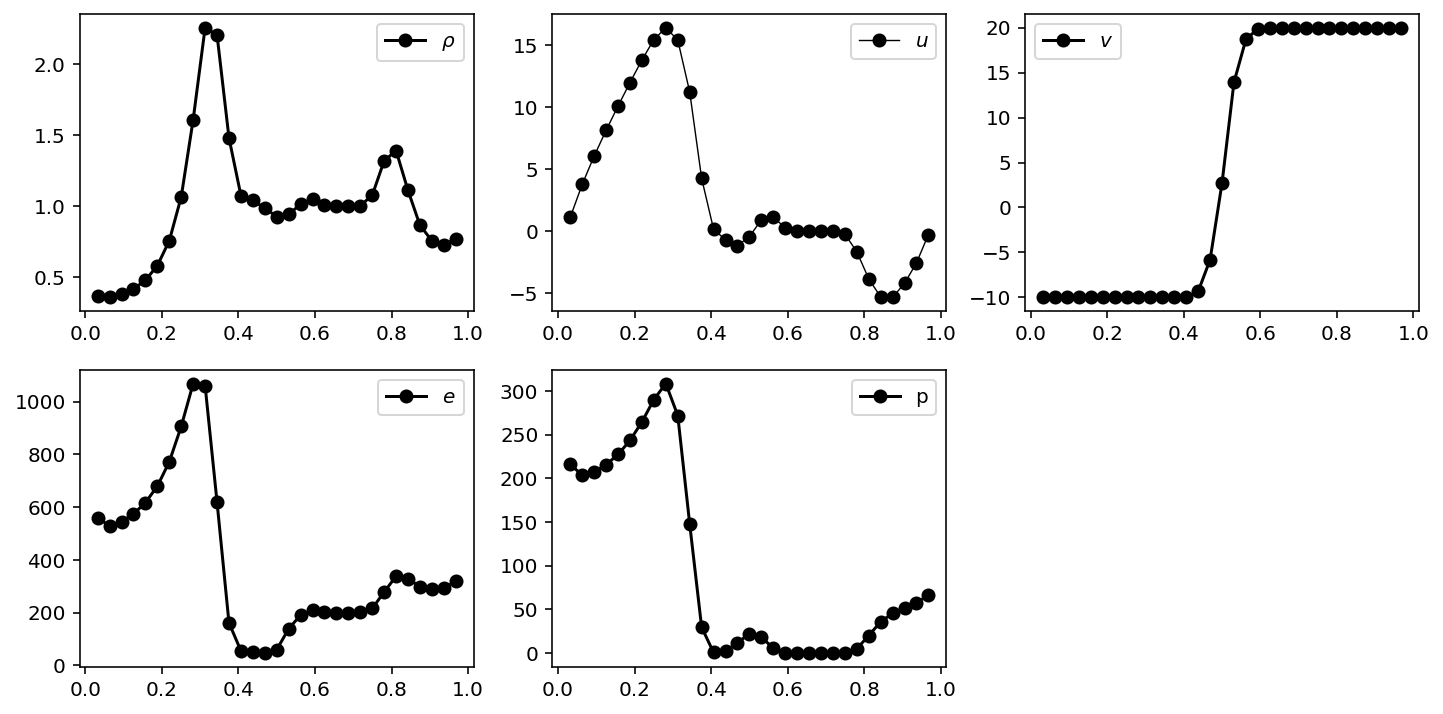

In [12]:
r1, u, v, e, p, x_s = Numerical_Solu(0.01, 31, 20)
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
plt.subplot(2,3,1)
plt.plot(x_s, r1, 'ko-',label = '$\\rho$')
plt.legend(loc = 0)
plt.subplot(2,3,2)
plt.plot(x_s, u, 'ko-',label = '$u$', lw = 0.7)
plt.legend(loc = 0)
plt.subplot(2,3,3)
plt.plot(x_s, v,'ko-',label = '$v$')
plt.legend(loc = 0)
plt.subplot(2,3,4)
plt.plot(x_s, e,'ko-',label = '$e$')
plt.legend(loc = 0)
plt.subplot(2,3,5)
plt.plot(x_s, p,'ko-',label = 'p')
plt.legend(loc = 0)

fig.delaxes(axs[1, 2])

In [6]:
r1, u, v, e, p, x_s = Numerical_Solu(0.02, 41, 40)

100%|█████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 383.23it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 431.86it/s]


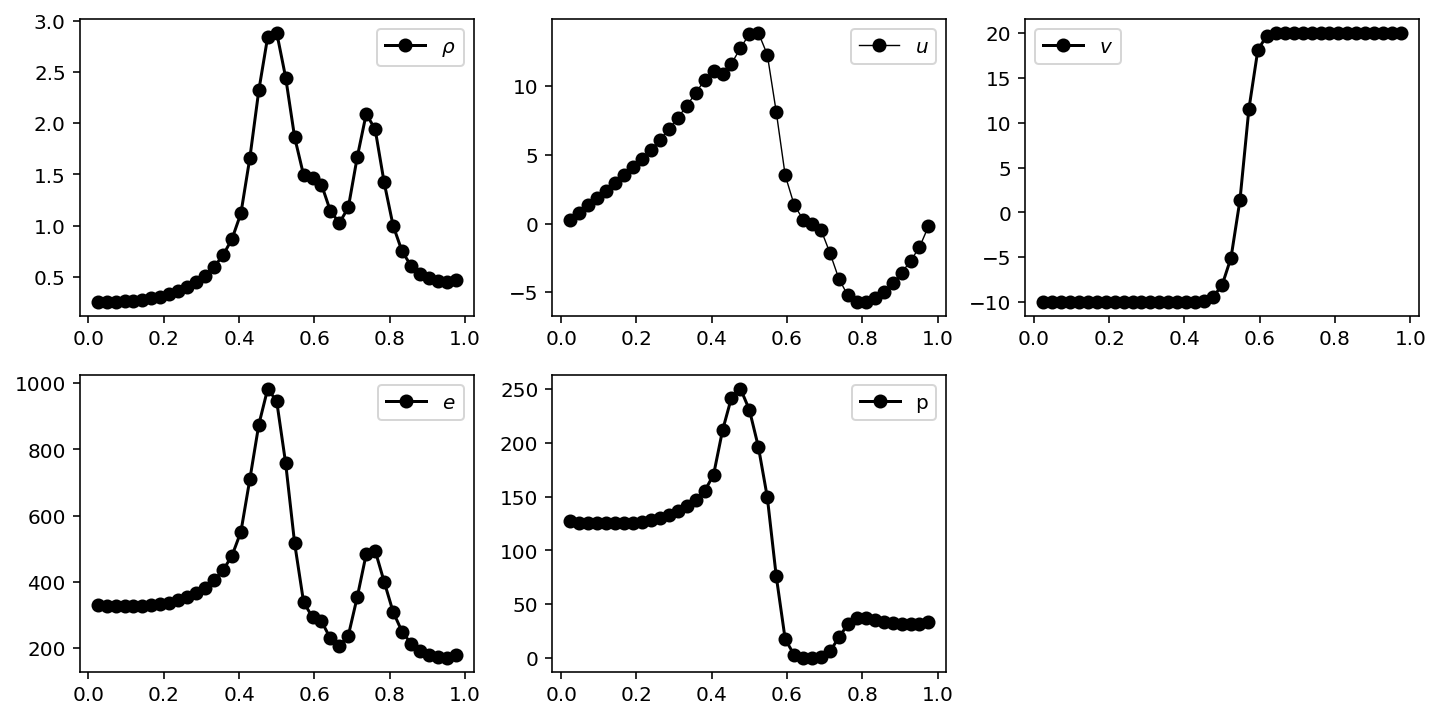

In [11]:
r1, u, v, e, p, x_s = Numerical_Solu(0.02, 41, 40)
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
plt.subplot(2,3,1)
plt.plot(x_s, r1, 'ko-',label = '$\\rho$')
plt.legend(loc = 0)
plt.subplot(2,3,2)
plt.plot(x_s, u, 'ko-',label = '$u$', lw = 0.7)
plt.legend(loc = 0)
plt.subplot(2,3,3)
plt.plot(x_s, v,'ko-',label = '$v$')
plt.legend(loc = 0)
plt.subplot(2,3,4)
plt.plot(x_s, e,'ko-',label = '$e$')
plt.legend(loc = 0)
plt.subplot(2,3,5)
plt.plot(x_s, p,'ko-',label = 'p')
plt.legend(loc = 0)

fig.delaxes(axs[1, 2])

100%|█████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 443.60it/s]


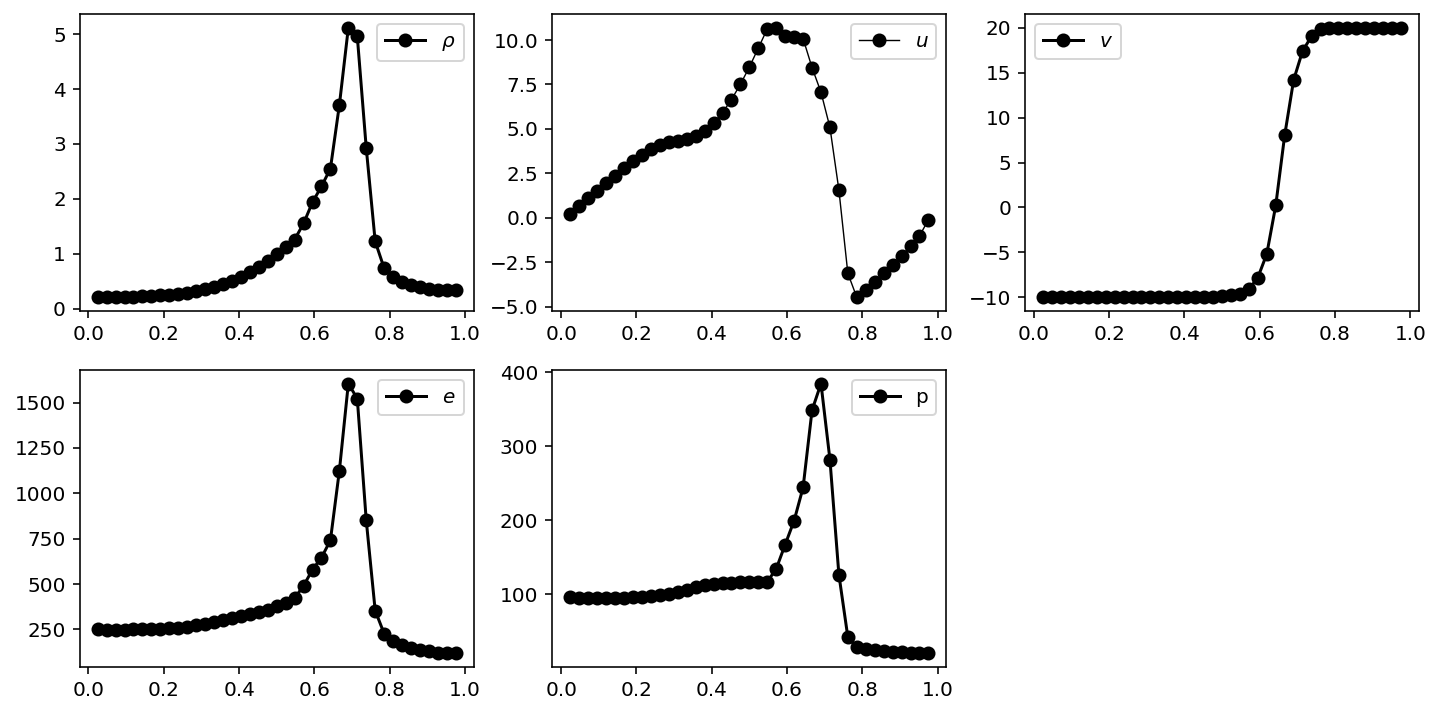

In [9]:
r1, u, v, e, p, x_s = Numerical_Solu(0.03, 41, 60)
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
plt.subplot(2,3,1)
plt.plot(x_s, r1, 'ko-',label = '$\\rho$')
plt.legend(loc = 0)
plt.subplot(2,3,2)
plt.plot(x_s, u, 'ko-',label = '$u$', lw = 0.7)
plt.legend(loc = 0)
plt.subplot(2,3,3)
plt.plot(x_s, v,'ko-',label = '$v$')
plt.legend(loc = 0)
plt.subplot(2,3,4)
plt.plot(x_s, e,'ko-',label = '$e$')
plt.legend(loc = 0)
plt.subplot(2,3,5)
plt.plot(x_s, p,'ko-',label = 'p')
plt.legend(loc = 0)

fig.delaxes(axs[1, 2])

100%|█████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 445.13it/s]


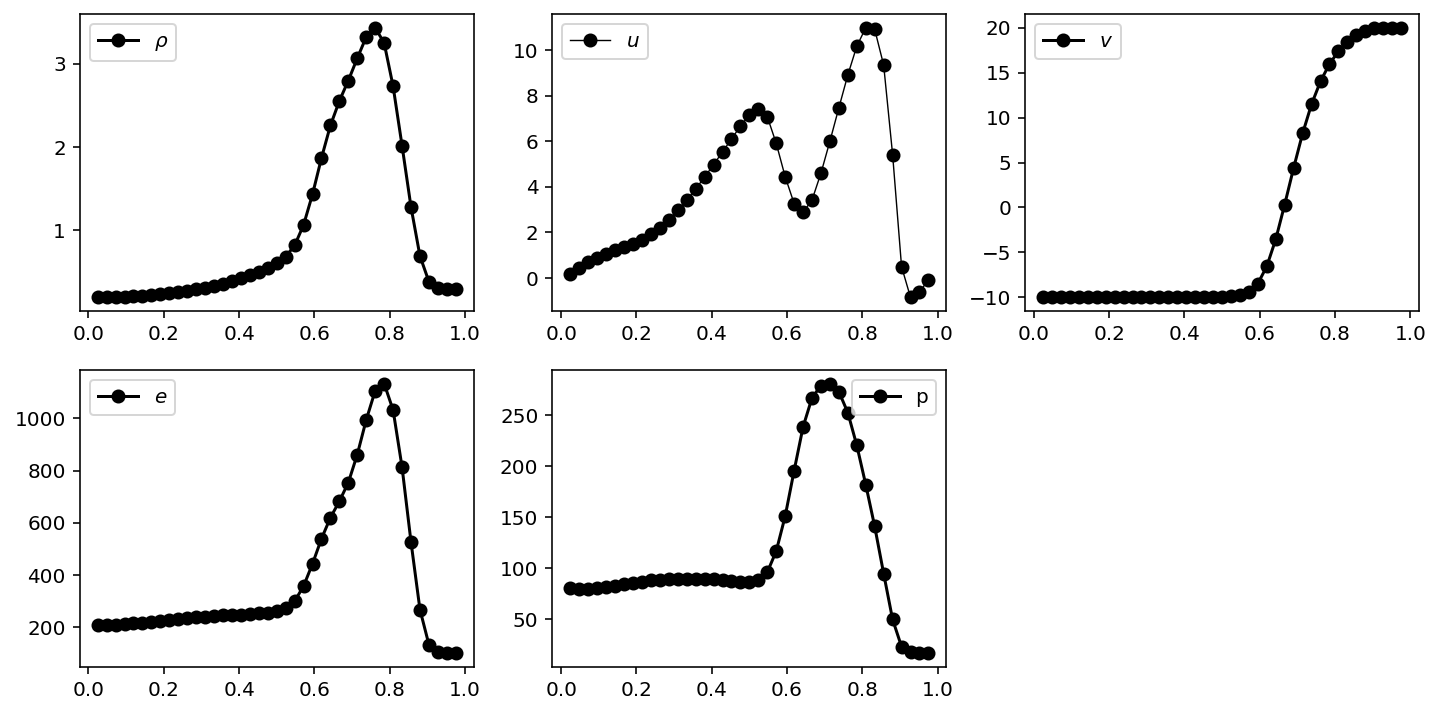

In [10]:
r1, u, v, e, p, x_s = Numerical_Solu(0.038, 41, 60)
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
plt.subplot(2,3,1)
plt.plot(x_s, r1, 'ko-',label = '$\\rho$')
plt.legend(loc = 0)
plt.subplot(2,3,2)
plt.plot(x_s, u, 'ko-',label = '$u$', lw = 0.7)
plt.legend(loc = 0)
plt.subplot(2,3,3)
plt.plot(x_s, v,'ko-',label = '$v$')
plt.legend(loc = 0)
plt.subplot(2,3,4)
plt.plot(x_s, e,'ko-',label = '$e$')
plt.legend(loc = 0)
plt.subplot(2,3,5)
plt.plot(x_s, p,'ko-',label = 'p')
plt.legend(loc = 0)

fig.delaxes(axs[1, 2])